In [1]:
!pip install anaflow

In [2]:
import numpy as np
import sympy as sp
import anaflow
import pandas as pd
import scipy.integrate as integrate
import scipy.special as sc
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 15; mp.pretty = True

##Задача
###Рассмотрим неустановившийся приток к вертикальной скважине, неполностью вскрывшей пласт бурением, с глубиной вскрытия hw в в бесконечном однородном горизонтальном пласте постоянной толщины h с начальным давлением pi и с непроницаемой верхней и нижней границами.

###Исходные данные

In [3]:
#Исходные данные
q = 0.00092 # [m3/c] - дебит скважины
B = 1.25 # [m3/m3] - объемный коэффициент
k = 5*1e-15 # [m2] - изотропная проницаемость
h = 9.144 # [m] - толщина пласта
f = 0.3 # [] - пористость
c = 1.47*1e-9 # [1/Pa] - сжимаемость флюида
cf = 1 * 1e-9 # [1/Pa] - сжимаемость породы
ct = (c + cf) # [1/Pa] - общая породы
rw = 0.1524 # [m] - радиус ствола скважины
r = 0.1524 # [m] - радиальная координата и расстояние
mu = 3*1e-3 # [Pa*c] - вязкость
eta = k / (mu * f * ct) # коэф пьезопроводности 
eta_x = (eta ** 2 * 10) ** (1/2) # [] - коэффициент пьезопроводности в x направлении
eta_y = eta_x # [] - коэффициент пьезопроводности в y направлении
eta_z = 0.1 * eta_x # [] - коэффициент пьезопроводности в z направлении
x = rw # [m] - расстояние в x направлении
x_s = 0 # [m] - координата источника в x направлении
y = 0 # [m] - расстояние в y направлении
y_s = 0 # [m] - координата источника в y направлении
z = 3.5 # [m] - расстояние в z направлении
z_w = 5 # [m] - координата скважины в z направлении
t_s = 3
l = rw # обезразмеривающий параметр
tau = np.logspace(0,6,100) # [c] - время
t = np.logspace(2,9,1000) # [c] - время
h_w = 5 # [m] - длина скважины (частично вскрывающей пласта)
xd = 1
yd = 0
zd = 0


In [4]:
def td_2_t(td, eta = eta, l = l):
  return l ** 2 * td / eta

In [5]:
def rd(xd = xd, yd = yd, zd = zd):
  return (xd ** 2 + yd ** 2 + zd ** 2) ** 0.5

In [6]:
def hd(h = h, k = k, kz = 1 * k, l = l):
  return h * (k / kz) ** 0.5 / l

In [7]:
def func_vert_part_well(s, n, rd=rd(), hw = h_w, h = h, z = z, z_w = z_w, hd = hd()):
  return 1 / n * sc.kn(0, rd * (s + n ** 2 * np.pi ** 2 / hd ** 2) ** 0.5) * np.sin(n * np.pi *  hw / 2 / h) * np.cos(n * np.pi * z_w / h) * np.cos(n * np.pi  * z / h) 

In [8]:
def sum_vert_part_well(s):
  p = 0
  result_1 = func_vert_part_well(s,1)
  m = 1
  while (m < 500):
    result_1 += func_vert_part_well(s,m+1)
    m += 1
  return result_1

In [9]:
def vert_part_well(s, q = q, mu = mu, h = h, k = k, l = l, hd = hd(), h_w = h_w, rd = rd(), z_w = z_w , f = f, B = B):
  return q * mu * B / (2 * np.pi * k * h * s) * ( sc.kn(0, rd * s ** 0.5) + 4 * h  /h_w / np.pi * sum_vert_part_well(s) )

In [10]:
path = 'https://raw.githubusercontent.com/AvtomonovPavel/Method-of-sources/main/Examples./example_3.2'
df = pd.read_table(path, sep='\s+', engine = 'python')


Text(0, 0.5, 'dP, Па')

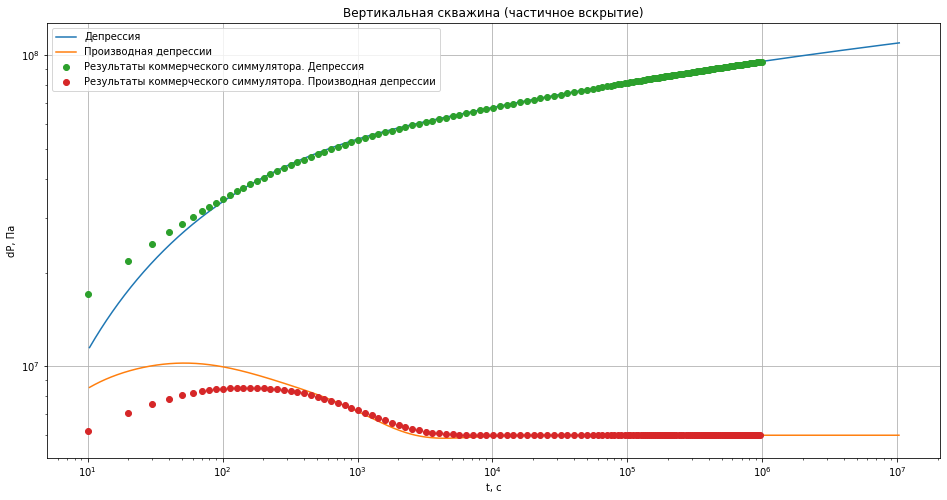

In [11]:
tau = np.logspace(0,6,3000) # [c] - время
pd_lps = anaflow.get_lap_inv(vert_part_well)
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
ax1.plot(td_2_t(tau), pd_lps(tau), label= 'Депрессия')
ax1.plot(td_2_t(tau)[:-1], np.diff( pd_lps(tau))/np.diff(td_2_t(tau)) * td_2_t(tau)[:-1], label = "Производная депрессии")
plt.title("Вертикальная скважина (частичное вскрытие)")
ax1.plot(df['dTime'], df['p-p@dt=0'],'o', label = 'Результаты коммерческого симмулятора. Депрессия')
ax1.plot(df['dTime'], df['Derivative'],'o', label = 'Результаты коммерческого симмулятора. Производная депрессии')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
plt.xlabel("t, c")
plt.ylabel("dP, Па")